# Predict Is Gene an Enzyme ?

* get dir: prot_models_bt30

# Predict Is Gene an Enzyme with ESM2 fined tuned model
## Visualize Attention map
#### Author: Fridman Naomi
#### Date: 2025-03-2
> transformer-based-enzyme-classification/blob/main/predict_is_gene_an_anzyme.ipynb

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/naomifridman/transformer-based-enzyme-classification/blob/main/predict_is_gene_an_anzyme.ipynb)

In [ ]:
# Check if running in Google Colab

if 'google.colab' in str(get_ipython()):
    print("Running in Google Colab")
    # Clone the repository
    !git clone https://github.com/naomifridman/transformer-based-enzyme-classification.git

    # Change to the repository directory
    os.chdir('/content/transformer-based-enzyme-classification')
    !wget https://zenodo.org/records/15640615/files/gmodels.tar.gz
    !tar xvfz models.tar.gz

In [52]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import utils as u

# Model upload
> Just run the cell

In [53]:
# ESM2 Sequence Classification
# Interactive protein sequence classification using ESM2

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ============================================================================
# 🔧 SETUP AND MODEL LOADING
# ============================================================================

print("🧬 ESM2 Sequence Classification Tool")
print("="*60)

# Device setup
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"📱 Using device: {device}")

# Model setup
model_checkpoint = "facebook/esm2_t12_35M_UR50D"
num_labels = 2

print("⏳ Loading model...")
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Load saved state dict and move to device
saved_state_dict = torch.load("models/esm2_model_classification_is_enzyme.pth", map_location=device)
model.load_state_dict(saved_state_dict)
model.to(device)
model.eval()

print("✅ Model loaded successfully!")

🧬 ESM2 Sequence Classification Tool
📱 Using device: cuda
⏳ Loading model...


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully!


## Input Sequances
> copy your sequances into sequence_1,sequence_2,sequence_3,sequence_4,sequence_5
> 
> leave "" for empty sequance

In [54]:
# ============================================================================
# 📝 SEQUENCE INPUT
# ============================================================================


sequence_1 = "MHNKIVRIASSALTGGKLLEKLKPLTRWEVQWDPNKTKCLGITREVTFKDYETTWAFLTRVSMRSHLWGHHPLIHTSYTWVKLELHTHDIDPKDGAHSQLSDIDVRMAKRIDSYIDEMTT" #P38744
sequence_2 = "MTEKHKTMGKFKVIVLAGTAGTGKSTIAGELIHEFKDIYPDLKFIEGDDLHPPANVEKMTRGIPLNDDDRWDWLKKVAVESTKAAASTKEHLSIVACSSLKKKYRDLIRHTCPESEFHFIFLYASKIEVLKRLKTRKGHFMKADMMESQFRDLELPDINDETDCDIVPLDFKTFYQIEKDVIQVVKSKVLNIE" #Q03786
sequence_3 = "MQIFVKTLTGKTITLEVEPSDTIENVKAKIQDKEGIPPDQQRLIFAGKQLEDGRTLSDYNIQKESTLHLVLRLRGG" 
sequence_4 = "" 
sequence_5 = "" 

## Predict Is Enzyne ?
> Just run the cell

In [55]:
show_plots = True 
save_results = False 

# Process sequences
raw_sequences = [sequence_1, sequence_2, sequence_3, sequence_4, sequence_5]
sequences = [seq.strip().replace(' ', '').replace('\n', '').upper() for seq in raw_sequences if seq.strip()]

print(f"\n📊 Found {len(sequences)} sequence(s) to analyze:")
for i, seq in enumerate(sequences):
    print(f"  • Sequence {i+1}: {len(seq)} amino acids")
    if len(seq) > 60:
        print(f"    Preview: {seq[:30]}...{seq[-30:]}")
    else:
        print(f"    Sequence: {seq}")

if not sequences:
    print("⚠️ No sequences provided. Please enter at least one sequence above.")
else:
    # ============================================================================
    # 🔮 PREDICTION
    # ============================================================================
    
    print(f"\n🧠 Running ESM2 classification...")
    
    # Tokenize sequences
    tokenized = tokenizer(sequences, max_length=512, padding=True, truncation=True, return_tensors='pt')
    
    # Move tokenized data to device
    tokenized = {key: val.to(device) for key, val in tokenized.items()}
    
    # Make predictions
    with torch.no_grad():
        outputs = model(**tokenized)
    
    # Calculate probabilities and predictions
    softmax = torch.nn.Softmax(dim=1)
    probs = softmax(outputs.logits)
    pred_class = torch.argmax(probs, dim=1)
    y_pred = probs[:, 1]  # Probability of class 1
    
    # Convert to numpy
    probs_np = probs.cpu().numpy()
    pred_class_np = pred_class.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()
    
    print("✅ Predictions completed!")
    
    # ============================================================================
    # 📊 RESULTS
    # ============================================================================
    
    # Create results table
    print(f"\n{'='*80}")
    print("🎯 CLASSIFICATION RESULTS")
    print(f"{'='*80}")
    
    results_data = []
    for i, (seq, pred, prob_all) in enumerate(zip(sequences, pred_class_np, probs_np)):
        confidence = max(prob_all)
        
        print(f"\n🧬 Sequence {i+1}:")
        print(f"   Length: {len(seq)} amino acids")
        print(f"   Prediction: Class {pred}")
        print(f"   Confidence: {confidence:.4f}")
        print(f"   Probabilities: Class 0: {prob_all[0]:.4f} | Class 1: {prob_all[1]:.4f}")
        
        # Determine prediction interpretation
        if pred == 0:
            interpretation = "Not an Enzyme" if confidence > 0.7 else "Likely Negative"
        else:
            interpretation = "an Enzyme" if confidence > 0.7 else "Likely Positive"
        
        print(f"   Interpretation: {interpretation}")
        
        results_data.append({
            'Sequence_ID': f'Seq_{i+1}',
            'Length': len(seq),
            'Predicted_Class': int(pred),
            'Confidence': f"{confidence:.4f}",
            'Class_0_Prob': f"{prob_all[0]:.4f}",
            'Class_1_Prob': f"{prob_all[1]:.4f}",
            'Interpretation': interpretation,
            'Sequence': seq[:100] + '...' if len(seq) > 100 else seq
        })
    
    # Create DataFrame
    results_df = pd.DataFrame(results_data)
    
    print(f"\n📋 SUMMARY TABLE:")
    print("="*80)
    display(results_df[['Sequence_ID', 'Length', 'Predicted_Class', 'Confidence', 'Interpretation']])


📊 Found 3 sequence(s) to analyze:
  • Sequence 1: 120 amino acids
    Preview: MHNKIVRIASSALTGGKLLEKLKPLTRWEV...DPKDGAHSQLSDIDVRMAKRIDSYIDEMTT
  • Sequence 2: 193 amino acids
    Preview: MTEKHKTMGKFKVIVLAGTAGTGKSTIAGE...CDIVPLDFKTFYQIEKDVIQVVKSKVLNIE
  • Sequence 3: 76 amino acids
    Preview: MQIFVKTLTGKTITLEVEPSDTIENVKAKI...GKQLEDGRTLSDYNIQKESTLHLVLRLRGG

🧠 Running ESM2 classification...
✅ Predictions completed!

🎯 CLASSIFICATION RESULTS

🧬 Sequence 1:
   Length: 120 amino acids
   Prediction: Class 0
   Confidence: 0.9323
   Probabilities: Class 0: 0.9323 | Class 1: 0.0677
   Interpretation: Not an Enzyme

🧬 Sequence 2:
   Length: 193 amino acids
   Prediction: Class 1
   Confidence: 0.9720
   Probabilities: Class 0: 0.0280 | Class 1: 0.9720
   Interpretation: an Enzyme

🧬 Sequence 3:
   Length: 76 amino acids
   Prediction: Class 0
   Confidence: 0.9984
   Probabilities: Class 0: 0.9984 | Class 1: 0.0016
   Interpretation: Not an Enzyme

📋 SUMMARY TABLE:


,Sequence_ID,Length,Predicted_Class,Confidence,Interpretation
0,Seq_1,120,0,0.9323,Not an Enzyme
1,Seq_2,193,1,0.9720,an Enzyme
2,Seq_3,76,0,0.9984,Not an Enzyme


## Save results
> Change 'sequence_classification_results.csv' to you prefared file name

> run the cell to save results

In [56]:
  
    # ============================================================================
    # 💾 SAVE RESULTS
    # ============================================================================
    
    if save_results:
        filename = 'sequence_classification_results.csv'
        results_df.to_csv(filename, index=False)
        print(f"💾 Results saved to {filename}")
    
    # Final summary
    print(f"\n🎉 Analysis Complete!")
    print(f"📊 Processed: {len(sequences)} sequences")
    print(f"🔴 Class 0 predictions: {sum(pred_class_np == 0)}")
    print(f"🔵 Class 1 predictions: {sum(pred_class_np == 1)}")
    
    avg_confidence = np.mean([max(prob) for prob in probs_np])
    print(f"📈 Average confidence: {avg_confidence:.3f}")
    
    print("\n" + "="*60)
    print("🔬 Ready for new sequences! Edit the sequences above and re-run.")
    print("="*60)


🎉 Analysis Complete!
📊 Processed: 3 sequences
🔴 Class 0 predictions: 2
🔵 Class 1 predictions: 1
📈 Average confidence: 0.968

🔬 Ready for new sequences! Edit the sequences above and re-run.


# Analyze attention

In [57]:
seq = 'MHNKIVRIASSALTGGKLLEKLKPLTRWEVQWDPNKTKCLGITREVTFKDYETTWAFLTRVSMRSHLWGHHPLIHTSYTWVKLELHTHDIDPKDGAHSQLSDIDVRMAKRIDSYIDEMTT'

In [58]:
seq = 'MTEKHKTMGKFKVIVLAGTAGTGKSTIAGELIHEFKDIYPDLKFIEGDDLHPPANVEKMTRGIPLNDDDRWDWLKKVAVESTKAAASTKEHLSIVACSSLKKKYRDLIRHTCPESEFHFIFLYASKIEVLKRLKTRKGHFMKADMMESQFRDLELPDINDETDCDIVPLDFKTFYQIEKDVIQVVKSKVLNIE'

In [59]:
# ============================================================================
# 🔮 PREDICTION WITH ATTENTION EXTRACTION
# ============================================================================

print(f"\n🧠 Running ESM2 classification with attention extraction...")

# Tokenize sequences
tokenized = tokenizer([seq], max_length=512, padding=True, truncation=True, return_tensors='pt')

# Move tokenized data to device
tokenized = {key: val.to(device) for key, val in tokenized.items()}

# Make predictions with attention output
with torch.no_grad():
    outputs = model(**tokenized, output_attentions=True)  # Enable attention output

# Calculate probabilities and predictions
softmax = torch.nn.Softmax(dim=1)
probs = softmax(outputs.logits)
pred_class = torch.argmax(probs, dim=1)
y_pred = probs[:, 1]

# Extract attention weights
attentions = outputs.attentions  # Tuple of attention tensors for each layer
# Shape: (batch_size, num_heads, sequence_length, sequence_length)

print("✅ Predictions and attention extraction completed!")
print(f"📊 Attention tensor shape: {attentions[0].shape}")
print(f"📈 Number of layers: {len(attentions)}")


🧠 Running ESM2 classification with attention extraction...
✅ Predictions and attention extraction completed!
📊 Attention tensor shape: torch.Size([1, 20, 195, 195])
📈 Number of layers: 12


## setup layer parameters

In [79]:

layer_idx=11 # layer index 0-11

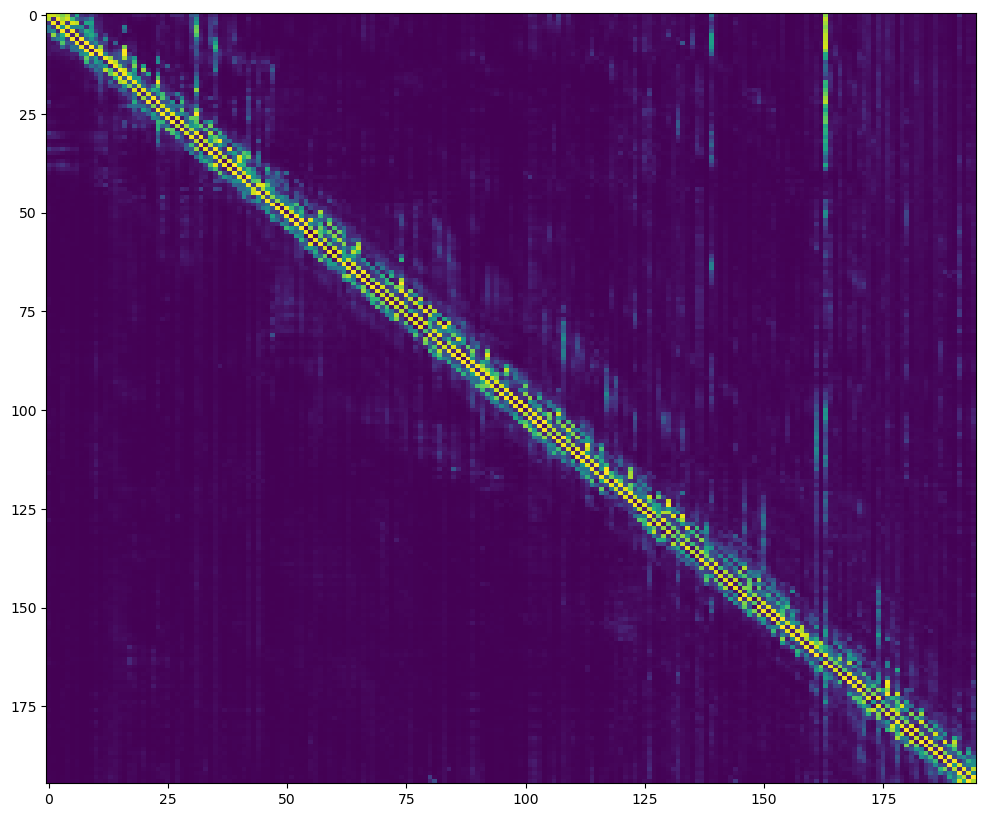

In [80]:
# Correct way to use max aggregation
attention_map_max = attentions[layer_idx].squeeze(0).max(dim=0)[0].detach().cpu().numpy()
plt.figure(figsize=(12, 10))
im = plt.imshow(attention_map_max, cmap='viridis', aspect='auto')

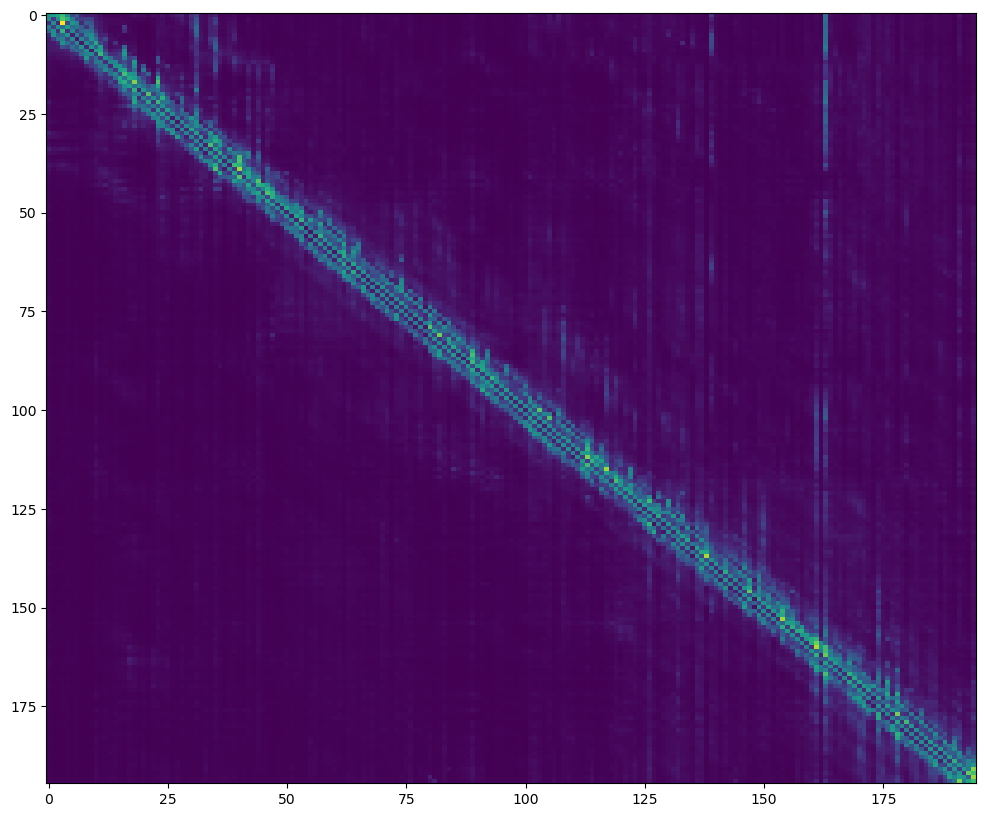

In [81]:
attention_map_mean = attentions[layer_idx].squeeze(0).mean(dim=0).detach().cpu().numpy()
plt.figure(figsize=(12, 10))
im = plt.imshow(attention_map_mean, cmap='viridis', aspect='auto')

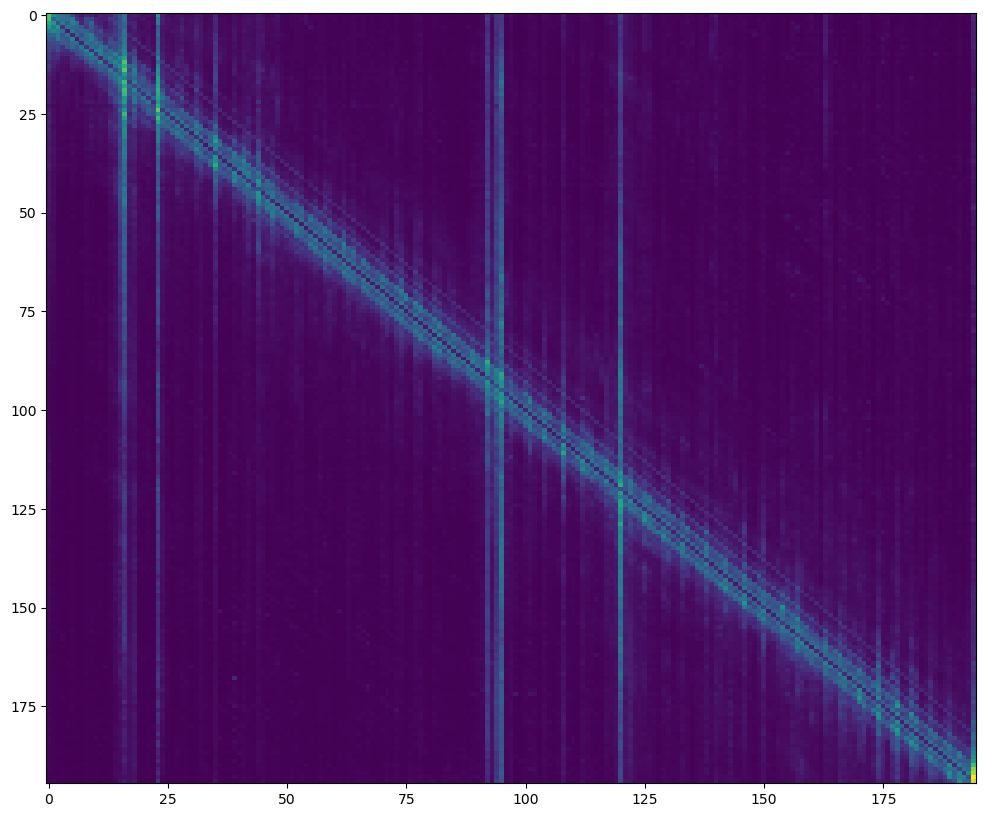

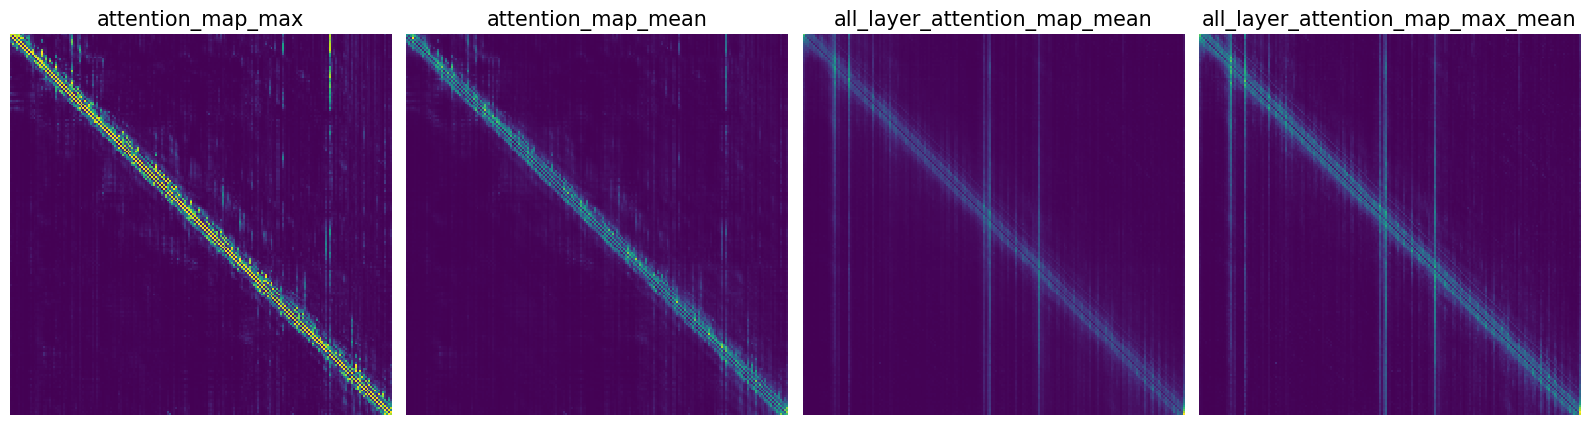

In [82]:


# Assuming attentions is a list/tensor with shape [12, 1, 20, nx, ny]
all_layers_attention = torch.stack([attentions[i] for i in range(12)]) 

# Average across layers, then across heads, then convert to numpy
all_layer_attention_map_mean = all_layers_attention.mean(dim=0).squeeze(0).mean(dim=0).detach().cpu().numpy()  # Shape: [nx, ny]
# Max across layers, mean across heads (often more balanced)
all_layer_attention_map_max_mean = all_layers_attention.max(dim=0)[0].squeeze(0).mean(dim=0).detach().cpu().numpy()
plt.figure(figsize=(12, 10))
im = plt.imshow(all_layer_attention_map_max_mean, cmap='viridis', aspect='auto')
u.show_n_images([attention_map_max,attention_map_mean,
                 all_layer_attention_map_mean, all_layer_attention_map_max_mean], 
                titles=['attention_map_max','attention_map_mean',
                 'all_layer_attention_map_mean', 'all_layer_attention_map_max_mean'],cmap='viridis')

### Choose attention map
> attention_map_max,

> attention_map_mean,
                 
> all_layer_attention_map_mean, 

> all_layer_attention_map_max_mean

In [83]:
attention_map=all_layer_attention_map_max_mean

In [65]:
# Define your range parameters
column_start = 60  
column_end = 120   
row_start = 60     
row_end = 120      

In [97]:
# Define your range parameters
column_start = 25 
column_end = 95   
row_start = 25    
row_end = 95    

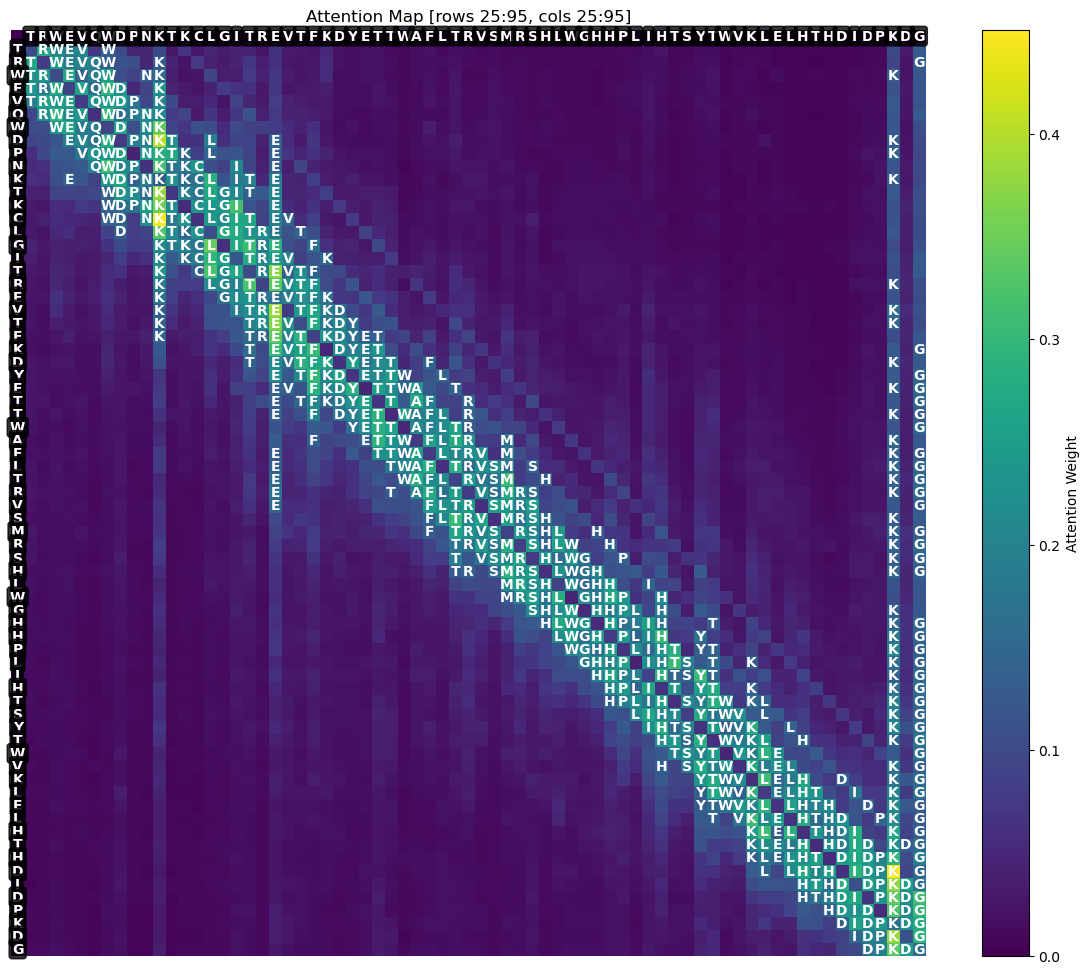

In [98]:
    

# Extract the submatrix using your specified range
sub_attention = attention_map[row_start:row_end, column_start:column_end]

# Get the corresponding sequence parts
row_sequence = sequence_1[row_start:row_end]
col_sequence = sequence_1[column_start:column_end]

#Make sure we don't exceed sequence length
max_rows = min(sub_attention.shape[0], len(row_sequence))
max_cols = min(sub_attention.shape[1], len(col_sequence))
sub_attention = sub_attention[:max_rows, :max_cols]

# Create an expanded matrix with space for labels
expanded_matrix = np.zeros((max_rows + 1, max_cols + 1))

# Fill the attention part (offset by 1 to leave space for labels)
expanded_matrix[1:max_rows+1, 1:max_cols+1] = sub_attention

plt.figure(figsize=(12, 10))
im = plt.imshow(expanded_matrix, cmap='viridis', aspect='auto')

# Add row labels (left border)
for i in range(max_rows):
    if i < len(row_sequence):
        plt.text(0, i+1, row_sequence[i], ha='center', va='center', 
                 color='white', fontsize=10, weight='bold',
                 bbox=dict(boxstyle="round,pad=0.2", facecolor="black", alpha=0.8))

# Add column labels (top border)
for j in range(max_cols):
    if j < len(col_sequence):
        plt.text(j+1, 0, col_sequence[j], ha='center', va='center', 
                 color='white', fontsize=10, weight='bold',
                 bbox=dict(boxstyle="round,pad=0.2", facecolor="black", alpha=0.8))

# Add only column characters on high attention pixels
threshold = np.percentile(sub_attention, 85)  # Top 15% of attention values
for i in range(max_rows):
    for j in range(max_cols):
        if sub_attention[i, j] > threshold and j < len(col_sequence):
            col_char = col_sequence[j]
            plt.text(j+1, i+1, col_char, ha='center', va='center', 
                    color='white', fontsize=10, weight='bold')

plt.title(f'Attention Map [rows {row_start}:{row_end}, cols {column_start}:{column_end}]')
plt.colorbar(im, label='Attention Weight')
plt.tight_layout()
plt.axis('off')
plt.show()

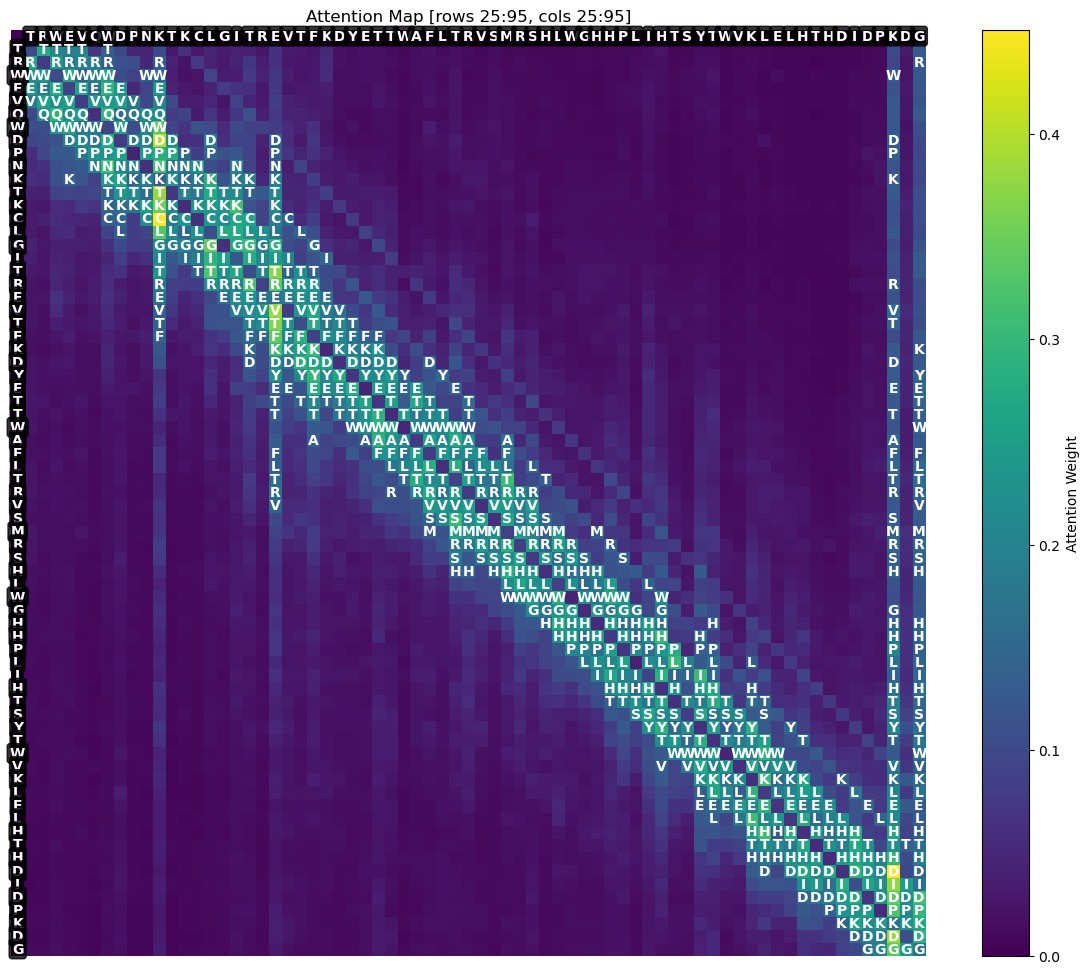

In [99]:
# Extract the submatrix using your specified range
sub_attention = attention_map[row_start:row_end, column_start:column_end]
# Get the corresponding sequence parts
row_sequence = sequence_1[row_start:row_end]
col_sequence = sequence_1[column_start:column_end]
#Make sure we don't exceed sequence length
max_rows = min(sub_attention.shape[0], len(row_sequence))
max_cols = min(sub_attention.shape[1], len(col_sequence))
sub_attention = sub_attention[:max_rows, :max_cols]
# Create an expanded matrix with space for labels
expanded_matrix = np.zeros((max_rows + 1, max_cols + 1))
# Fill the attention part (offset by 1 to leave space for labels)
expanded_matrix[1:max_rows+1, 1:max_cols+1] = sub_attention
plt.figure(figsize=(12, 10))
im = plt.imshow(expanded_matrix, cmap='viridis', aspect='auto')
# Add row labels (left border)
for i in range(max_rows):
    if i < len(row_sequence):
        plt.text(0, i+1, row_sequence[i], ha='center', va='center', 
                 color='white', fontsize=10, weight='bold',
                 bbox=dict(boxstyle="round,pad=0.2", facecolor="black", alpha=0.8))
# Add column labels (top border)
for j in range(max_cols):
    if j < len(col_sequence):
        plt.text(j+1, 0, col_sequence[j], ha='center', va='center', 
                 color='white', fontsize=10, weight='bold',
                 bbox=dict(boxstyle="round,pad=0.2", facecolor="black", alpha=0.8))
# Add only ROW characters on high attention pixels
threshold = np.percentile(sub_attention, 85)  # Top 15% of attention values
for i in range(max_rows):
    for j in range(max_cols):
        if sub_attention[i, j] > threshold and i < len(row_sequence):
            row_char = row_sequence[i]  # Changed from col_sequence[j] to row_sequence[i]
            plt.text(j+1, i+1, row_char, ha='center', va='center', 
                    color='white', fontsize=10, weight='bold')
plt.title(f'Attention Map [rows {row_start}:{row_end}, cols {column_start}:{column_end}]')
plt.colorbar(im, label='Attention Weight')
plt.tight_layout()
plt.axis('off')
plt.show()

## Zoom in

In [100]:
attention_map=all_layer_attention_map_max_mean

In [101]:
# Define your range parameters
column_start = 80  
column_end = 120   
row_start = 80     
row_end = 122    

In [102]:
# Define your range parameters
column_start = 0 
column_end = 50   
row_start = 0     
row_end = 50    

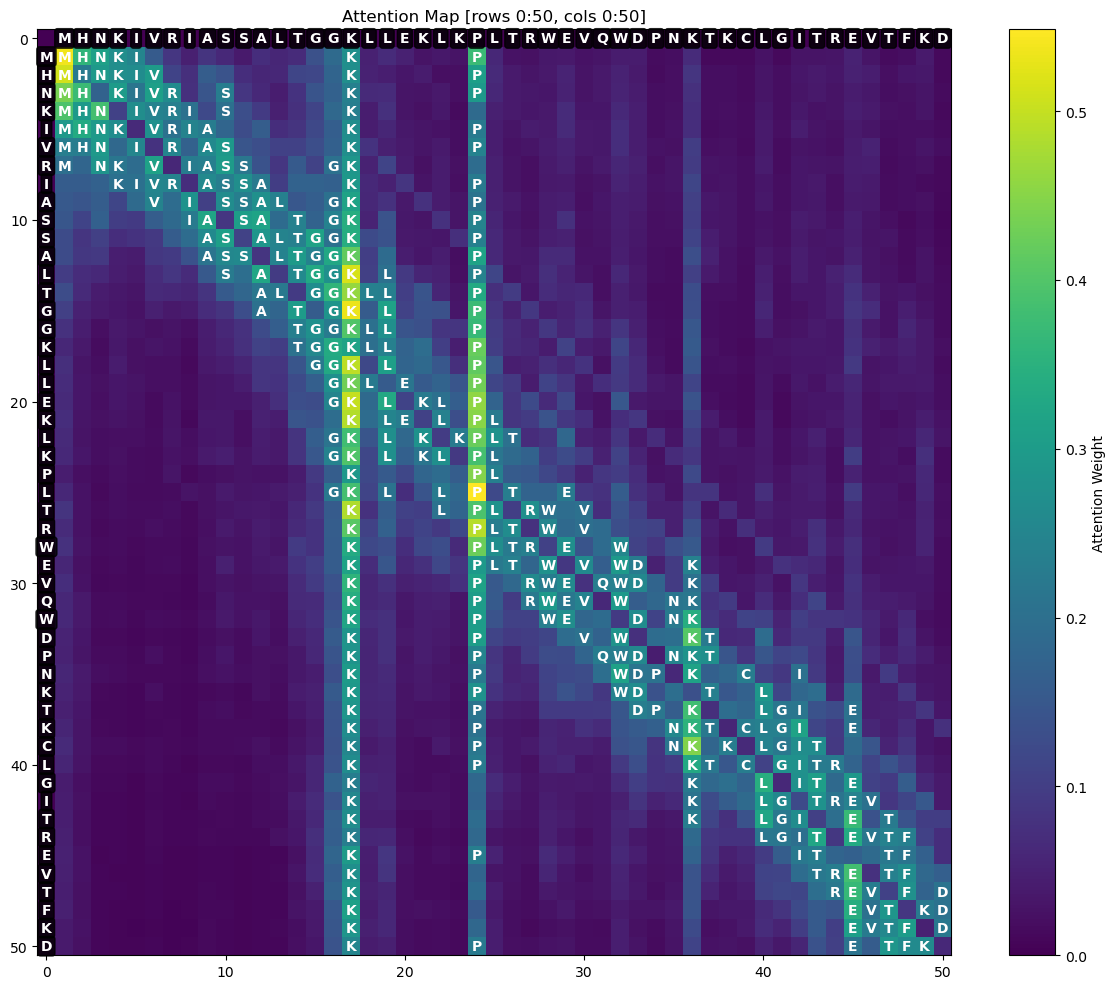

In [103]:
    

# Extract the submatrix using your specified range
sub_attention = attention_map[row_start:row_end, column_start:column_end]

# Get the corresponding sequence parts
row_sequence = sequence_1[row_start:row_end]
col_sequence = sequence_1[column_start:column_end]

#Make sure we don't exceed sequence length
max_rows = min(sub_attention.shape[0], len(row_sequence))
max_cols = min(sub_attention.shape[1], len(col_sequence))
sub_attention = sub_attention[:max_rows, :max_cols]

# Create an expanded matrix with space for labels
expanded_matrix = np.zeros((max_rows + 1, max_cols + 1))

# Fill the attention part (offset by 1 to leave space for labels)
expanded_matrix[1:max_rows+1, 1:max_cols+1] = sub_attention

plt.figure(figsize=(12, 10))
im = plt.imshow(expanded_matrix, cmap='viridis', aspect='auto')

# Add row labels (left border)
for i in range(max_rows):
    if i < len(row_sequence):
        plt.text(0, i+1, row_sequence[i], ha='center', va='center', 
                 color='white', fontsize=10, weight='bold',
                 bbox=dict(boxstyle="round,pad=0.2", facecolor="black", alpha=0.8))

# Add column labels (top border)
for j in range(max_cols):
    if j < len(col_sequence):
        plt.text(j+1, 0, col_sequence[j], ha='center', va='center', 
                 color='white', fontsize=10, weight='bold',
                 bbox=dict(boxstyle="round,pad=0.2", facecolor="black", alpha=0.8))

# Add only column characters on high attention pixels
threshold = np.percentile(sub_attention, 85)  # Top 15% of attention values
for i in range(max_rows):
    for j in range(max_cols):
        if sub_attention[i, j] > threshold and j < len(col_sequence):
            col_char = col_sequence[j]
            plt.text(j+1, i+1, col_char, ha='center', va='center', 
                    color='white', fontsize=10, weight='bold')

plt.title(f'Attention Map [rows {row_start}:{row_end}, cols {column_start}:{column_end}]')
plt.colorbar(im, label='Attention Weight')
plt.tight_layout()
plt.show()